Top 5 delitos:
 shape: (5, 2)
┌───────────────────────────────┬────────┐
│ delito                        ┆ total  │
│ ---                           ┆ ---    │
│ str                           ┆ u32    │
╞═══════════════════════════════╪════════╡
│ violencia familiar            ┆ 112803 │
│ robo a vehiculos particulares ┆ 109048 │
│ robo a persona                ┆ 90325  │
│ lesiones dolosas              ┆ 84151  │
│ robo a negocio                ┆ 81196  │
└───────────────────────────────┴────────┘


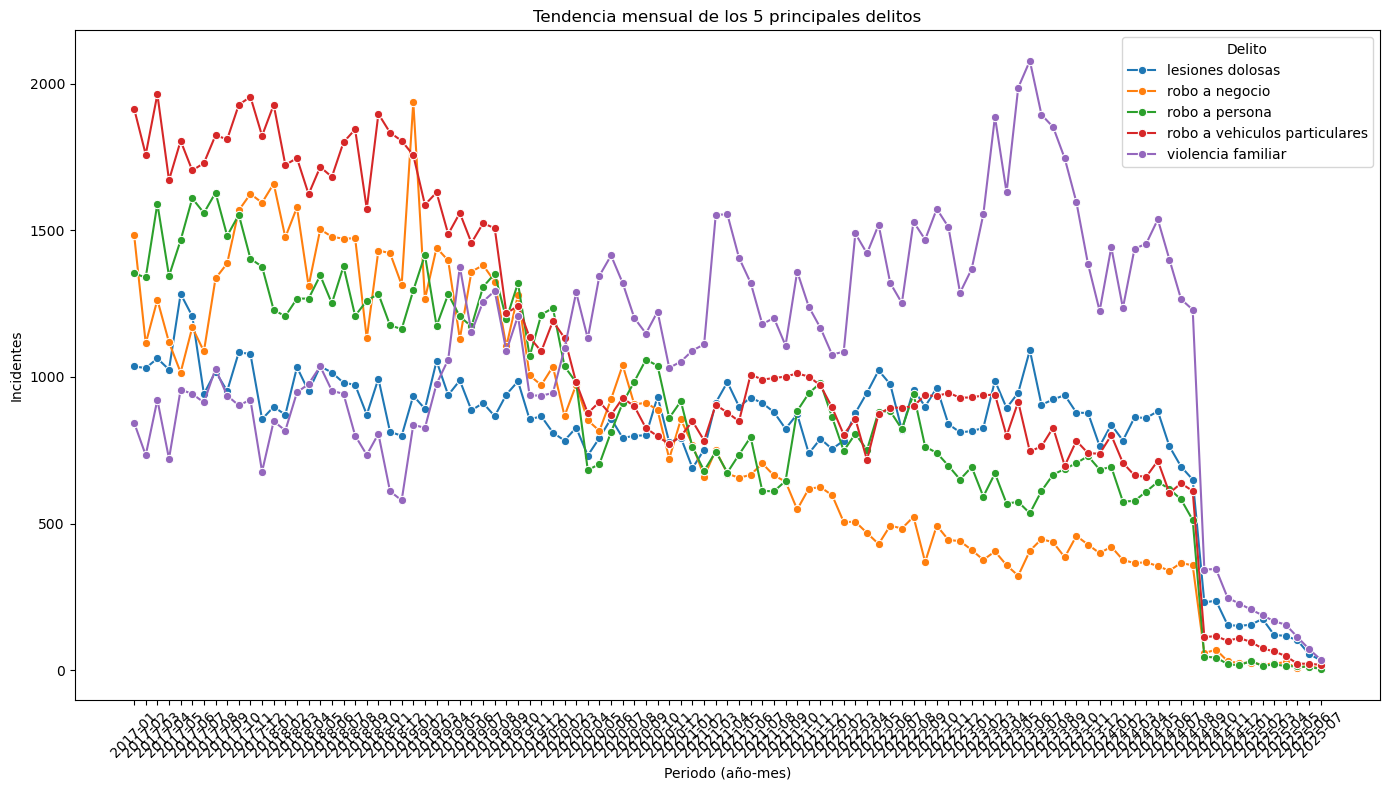

Top municipios por Homicidio:
 shape: (10, 4)
┌───────────────────────┬──────────────────┬──────┬────────────┐
│ municipio             ┆ delito           ┆ año  ┆ incidentes │
│ ---                   ┆ ---              ┆ ---  ┆ ---        │
│ str                   ┆ str              ┆ i32  ┆ u32        │
╞═══════════════════════╪══════════════════╪══════╪════════════╡
│ guadalajara           ┆ homicidio doloso ┆ 2018 ┆ 477        │
│ guadalajara           ┆ homicidio doloso ┆ 2021 ┆ 400        │
│ guadalajara           ┆ homicidio doloso ┆ 2019 ┆ 362        │
│ guadalajara           ┆ homicidio doloso ┆ 2020 ┆ 360        │
│ san pedro tlaquepaque ┆ homicidio doloso ┆ 2018 ┆ 325        │
│ san pedro tlaquepaque ┆ homicidio doloso ┆ 2019 ┆ 306        │
│ san pedro tlaquepaque ┆ homicidio doloso ┆ 2021 ┆ 295        │
│ san pedro tlaquepaque ┆ homicidio doloso ┆ 2020 ┆ 291        │
│ san pedro tlaquepaque ┆ homicidio doloso ┆ 2023 ┆ 279        │
│ tlajomulco de zuniga  ┆ homicidio doloso ┆

/tmp/ipykernel_29235/3408531239.py:66: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("incidentes"))
/tmp/ipykernel_29235/3408531239.py:94: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  crec_df = pl.DataFrame(crec_l, schema=["delito","inicial","final","tasa_cambio"])


In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


df = pl.read_parquet("data/iieg_data.parquet")
# df = df.with_columns([
#     pl.col("fecha").str.strptime(pl.Date, fmt="%Y-%m-%d").alias("fecha")
# ])


df = df.with_columns([
    df["fecha"].dt.year().alias("año"),
    df["fecha"].dt.month().alias("mes"),
])

# ============================
# Tendencia global por delito
# ============================
# Agregar conteos por año-mes
mensual = (
    df.group_by(["delito", "año", "mes"])
      .agg(pl.len().alias("incidentes"))
      .sort(["delito","año","mes"])
)

# Crear columna periodo YYYY-MM para graficar
mensual = mensual.with_columns(
    (pl.col("año").cast(pl.Utf8) + "-" + pl.col("mes").cast(pl.Utf8).str.zfill(2)).alias("periodo")
)

# ============================
# Top delitos por frecuencia total
# ============================
top_delitos = (
    mensual.group_by("delito")
           .agg(pl.sum("incidentes").alias("total"))
           .sort("total", descending=True)
           .head(5)
)
print("Top 5 delitos:\n", top_delitos)

# ============================
# Graficar tendencias de los top delitos
# ============================
mensual_top = mensual.filter(pl.col("delito").is_in(top_delitos["delito"].to_list()))

plt.figure(figsize=(14,8))
sns.lineplot(
    data=mensual_top.to_pandas(),
    x="periodo", y="incidentes", hue="delito", marker="o"
)
plt.xticks(rotation=45)
plt.title("Tendencia mensual de los 5 principales delitos")
plt.xlabel("Periodo (año-mes)")
plt.ylabel("Incidentes")
plt.legend(title="Delito")
plt.tight_layout()
plt.show()

# ============================
# Tendencia anual por municipio y delito
# ============================
anual_muni = (
    df.group_by(["municipio","delito","año"])
      .agg(pl.count().alias("incidentes"))
      .sort(["municipio","delito","año"])
)

# Top 5 municipios con más homicidios
ejemplo = anual_muni.filter(pl.col("delito").str.contains("cidio")).sort("incidentes", descending=True).head(10)
print("Top municipios por Homicidio:\n", ejemplo)

# ============================
# Métricas de crecimiento (pendiente simple)
# ============================
# Calcular incremento relativo por delito entre primer y último año
crecimiento = (
    anual_muni.group_by(["delito","año"])
              .agg(pl.sum("incidentes").alias("total"))
              .sort(["delito","año"])
)

# Para cada delito, calcular tasa de crecimiento
crec_l = []
for delito, subdf in crecimiento.group_by("delito"):
    s = subdf.sort("año")
    if s.shape[0] > 1:
        inicial = s["total"][0]
        final = s["total"][-1]
        tasa = (final - inicial) / inicial if inicial > 0 else None
        crec_l.append([delito, inicial, final, tasa])
        
crec_df = pl.DataFrame(crec_l, schema=["delito","inicial","final","tasa_cambio"])
print("\nCrecimiento relativo por delito:\n", crec_df.sort("tasa_cambio", descending=True))


Totales anuales:
 shape: (9, 2)
┌──────┬──────────────────┐
│ año  ┆ total_incidentes │
│ ---  ┆ ---              │
│ i32  ┆ u32              │
╞══════╪══════════════════╡
│ 2017 ┆ 108527           │
│ 2018 ┆ 102857           │
│ 2019 ┆ 98815            │
│ 2020 ┆ 78089            │
│ 2021 ┆ 73412            │
│ 2022 ┆ 72506            │
│ 2023 ┆ 74120            │
│ 2024 ┆ 46799            │
│ 2025 ┆ 3083             │
└──────┴──────────────────┘


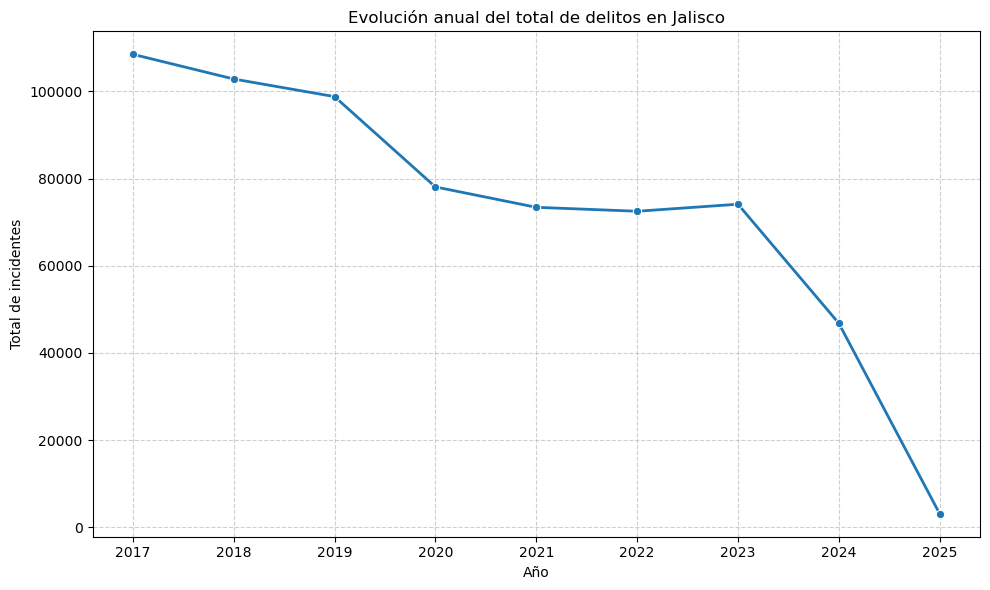

In [5]:
# ============================
# Evolución anual total de delitos
# ============================
total_anual = (
    df.group_by("año")
      .agg(pl.len().alias("total_incidentes"))
      .sort("año")
)

print("Totales anuales:\n", total_anual)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=total_anual.to_pandas(),
    x="año", y="total_incidentes", marker="o", linewidth=2
)
plt.title("Evolución anual del total de delitos en Jalisco")
plt.xlabel("Año")
plt.ylabel("Total de incidentes")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
